# 1 INTRODUCTION

## PROBLEM STATEMENT

* There are a large number of factors that can affect the value of a house property (eg. location, size, condition, time), these factors can change quite substantially from one property to another
* The housing market itself is quite a volatile industry, and is quite dependent on demand and supply fluctuations, not to even mention economic factors sch as interest rates & inflation, so its quite a challenge to predict the price variation over time
* It's also quite challenging to predict housing prices due to the limited data that is available, most datasets contain a limited number of features related to each property, such is why feature engineering is quite important
* As a result, it is generally quite difficult to accurately predict property prices that take into account all the factors that influence it
* The California housing dataaset contains different house related attributes for properties located in California

## STUDY AIM

* The aim is to model is to predict the median_house_value which is our target variable.
* Overcome missing data with a basic unsupervised learning data imputation
* Identification of outliers in a dataset
* Understand how to turn a simple model into your own sklearn comparible class, our aim won't be to create the most perfect model

In [112]:
import numpy as np
from numpy.linalg import pinv,inv
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns;sns.set(style='whitegrid')
%matplotlib inline

import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import BaseEstimator, RegressorMixin,ClassifierMixin
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
# from mllibs.bl_regressor import BR
pi = 4.0*np.arctan(1.0)

color1 = 'darkviolet'
color2 = 'indigo'

# 2 DATA PREPARATION 


## Loading the datset 

* df.info(),describe(),head() are probably one of the first things we might want to inspect having a pandas dataframe; showing feature names, limits/stats and and a few first columns respectively, to get a some initial impression of the data
* I have made some minor adjustment to the original dataset and pulled out some random data from all but two coordinate features, so we can do some data imputation, the dataset is located below, even though its not made public.

In [97]:
#Reading File
df = pd.read_csv("data\housing.csv")


In [3]:
df.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [98]:
# Let's show all columns with missing data as well:
df[df.isnull().any(axis=1)] # any missing data in columns

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
290      -122.16     37.77                47.0       1256.0             NaN   
341      -122.17     37.75                38.0        992.0             NaN   
538      -122.28     37.78                29.0       5154.0             NaN   
563      -122.24     37.75                45.0        891.0             NaN   
696      -122.10     37.69                41.0        746.0             NaN   
...          ...       ...                 ...          ...             ...   
20267    -119.19     34.20                18.0       3620.0             NaN   
20268    -119.18     34.19                19.0       2393.0             NaN   
20372    -118.88     34.17                15.0       4260.0             NaN   
20460    -118.75     34.29                17.0       5512.0             NaN   
20484    -118.72     34.28                17.0       3051.0             NaN   

       population  households  median_income  median_house_value  \
290         570.0       218.0         4.3750            161900.0   
341         732.0       259.0         1.6196             85100.0   
538        3741.0      1273.0         2.5762            173400.0   
563         384.0       146.0         4.9489            247100.0   
696         387.0       161.0         3.9063            178400.0   
...           ...         ...            ...                 ...   
20267      3171.0       779.0         3.3409            220500.0   
20268      1938.0       762.0         1.6953            167400.0   
20372      1701.0       669.0         5.1033            410700.0   
20460      2734.0       814.0         6.6073            258100.0   
20484      1705.0       495.0         5.7376            218600.0   

      ocean_proximity  
290          NEAR BAY  
341          NEAR BAY  
538          NEAR BAY  
563          NEAR BAY  
696          NEAR BAY  
...               ...  
20267      NEAR OCEAN  
20268      NEAR OCEAN  
20372       <1H OCEAN  
20460       <1H OCEAN  
20484       <1H OCEAN  

[207 rows x 10 columns]

## Data imputation 

* We can note that we have a number of features with some missing data, but not too many instances overall (257/20640);
* Lets try an Unsupervised Learning (UL) approach based on the kNN model, we can use the function below and pass a dataframe to generated an imputed dataframe

In [99]:
from sklearn.neighbors import KNeighborsRegressor

# function that imputes a dataframe 
def impute_knn(df):
    
    ''' inputs: pandas df containing feature matrix '''
    ''' outputs: dataframe with NaN imputed '''
    # imputation with KNN unsupervised method

    # separate dataframe into numerical/categorical
    ldf = df.select_dtypes(include=[np.number])           # select numerical columns in df
    ldf_putaside = df.select_dtypes(exclude=[np.number])  # select categorical columns in df
    # define columns w/ and w/o missing data
    cols_nan = ldf.columns[ldf.isna().any()].tolist()         # columns w/ nan 
    cols_no_nan = ldf.columns.difference(cols_nan).values     # columns w/o nan 

    for col in cols_nan:                
        imp_test = ldf[ldf[col].isna()]   # indicies which have missing data will become our test set
        imp_train = ldf.dropna()          # all indicies which which have no missing data 
        model = KNeighborsRegressor(n_neighbors=5)  # KNR Unsupervised Approach
        knr = model.fit(imp_train[cols_no_nan], imp_train[col])
        ldf.loc[df[col].isna(), col] = knr.predict(imp_test[cols_no_nan])
    
    return pd.concat([ldf,ldf_putaside],axis=1)

## Creating a hold-out set

* Thorough of the entire dataset & not having the availability of new data is undesirable.
* We want to reserve some data, & use it to see how good the model is at prediction on unseen data, so lets create it using train_test_split
trdata : Training Data Subset (Let's inspect the data as if we only had this data this)
tedata : Test Data Subset (Use this subset for model evaluation)

In [100]:
# Call function that imputes missing data
df2 = impute_knn(df)
# looks like we have a full feature matrix
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [101]:

from sklearn.model_selection import train_test_split# 70/30 Split should do
trdata,tedata = train_test_split(df2,test_size=0.3,random_state=43)

# EXPLORATORY DATA ANALYSIS (EDA)

## Univariate histograms

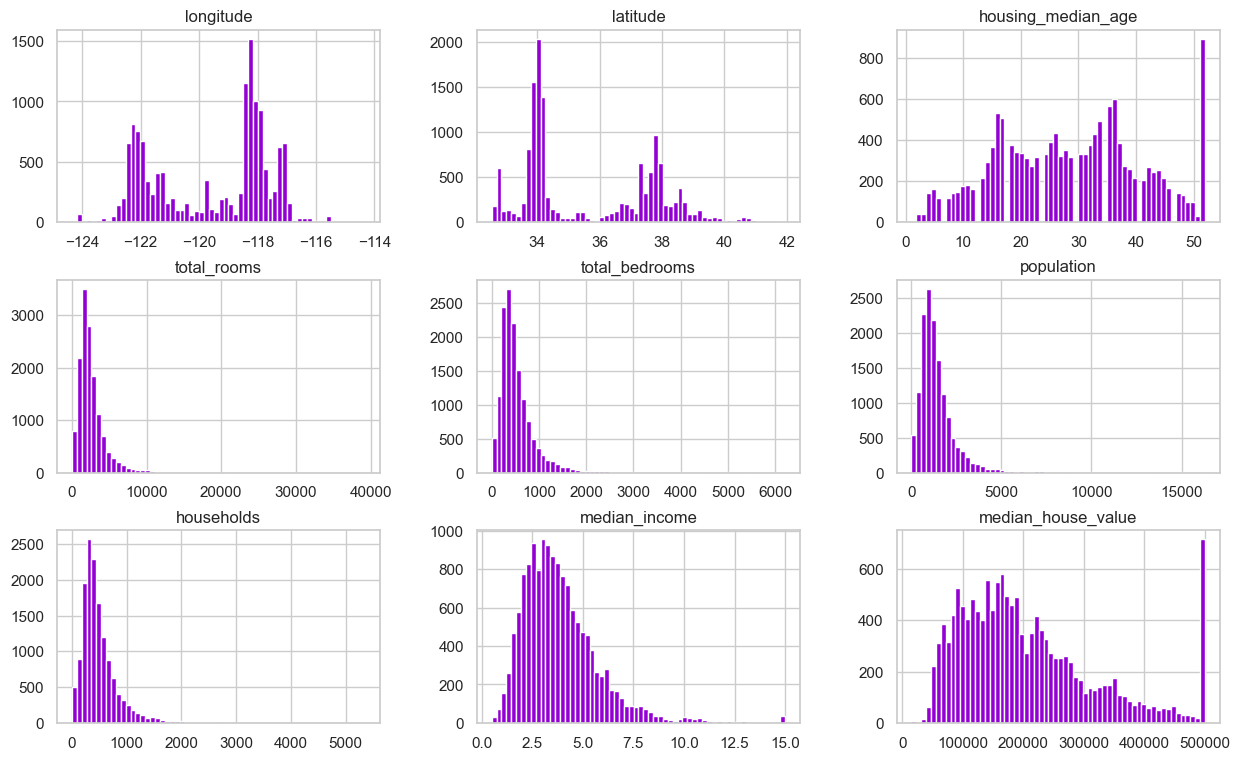

In [102]:
trdata.hist(bins=60, figsize=(15,9),color=color1);plt.show()

## Odd Patterns & Outliers
Data distributions which slightly sticks out:

*On first impression, a few outlier (inconsistent with entire set) groups are present in our data; possibly due to the way in which the data was sampled ( 'housing_median_age' & 'median_house_value' )
*House_median_age is one possible feature with such outliers. Also having a lot of local peaks (all are quite gradual) but one really odd peak at the maximum value stands out. It has some slight discontinuity in data (which becomes visible with the adjustment of bins)
*Feature Median_house_value has an odd peak at its maximum value (around 500k), which could be an outlier.

## Less Noticeable Outliers
* We have quite a few skewed (less centralised) data distributions, 6 features have such distributions, which is quite a lot and slightly concerning since we are going to use a relatively simple model.
* The range of the x axis for some of these features is quite broad (eg. population), indicating we have quite a few outliers, but unlike the first two, we can apply transformation to features and attempt to correct it.
* Population, total_bedrooms and total_rooms represent somewhat connected things, also have similar distribution which is skewed t owards smaller values.

# Bivariate correlation matrix

* Bivariate (Two Feature) Two-Feature relation ; correlation meature
* Very fast way to understand something about the dataset.
* Correlation matrix contains only information about the linear similarity of two feature relations

<Axes: >

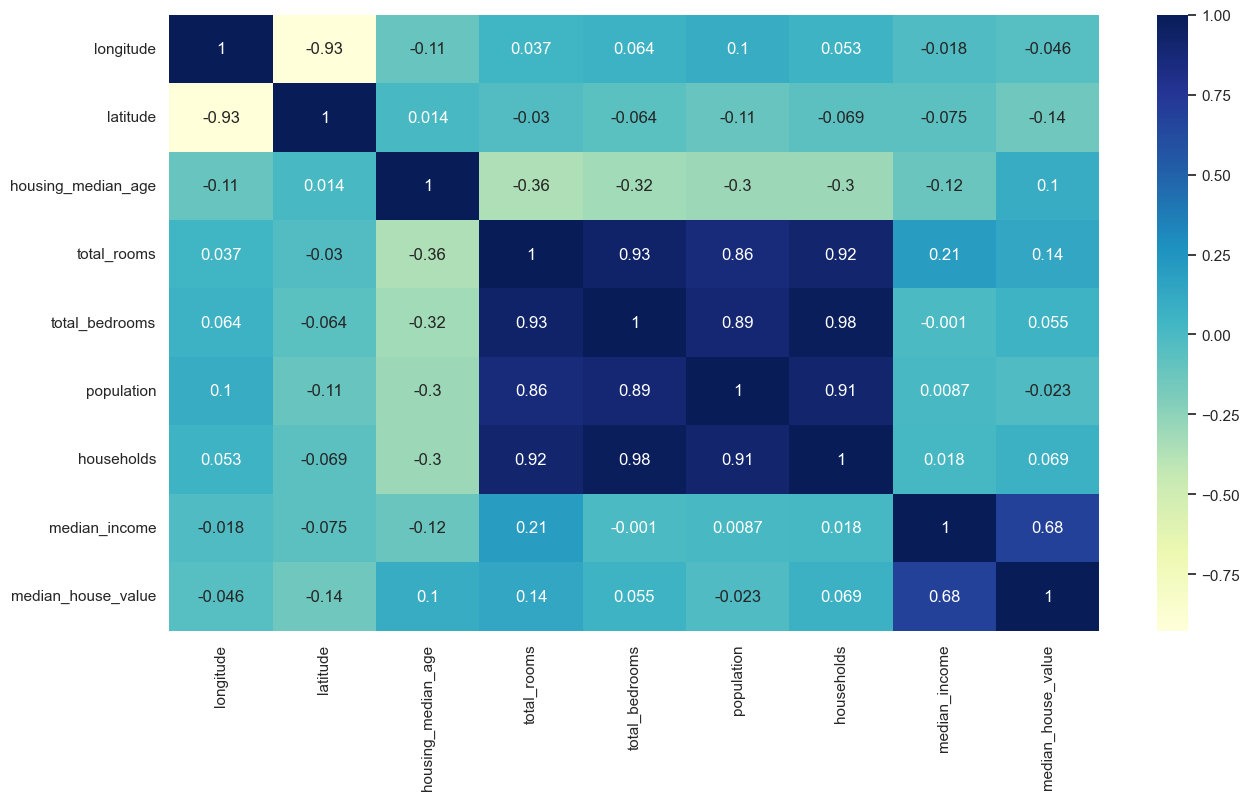

In [16]:
plt.figure(figsize=(15,8))
sns.heatmap((trdata.select_dtypes(include=[np.number]).corr()), annot=True, cmap="YlGnBu")

* Target variable median_house_value is very mildly correlated to all but one feature here: median_income, so one might outline this as an important feature.
* A correlation of -0.02 & -0.05 (population/longitude) to the target variable median_house_value might be worth dropping, but they might not be. In fact, a low value isn't exactly a reason to drop a feature. It could simply imply the data is spread quite a lot, which is a strong indicator of nonlinearity.
* It is often advised to drop such features, especially for less complex models, as the model probably won't be able to pick up on one feature with such nonlinearity, let alone multiple.

## Bivariate scattered data

* Pairplots/Scatter Matrices are very insightful & can be used to find interesting scatter platterns in bivariate (two feature data plots) relations
* Scatter plots allow the addition of color labelling, however its often quite difficult to distinguish between color labels in a scattered matrix

In [103]:
''' Draw a Bivariate Seaborn Pairgrid /w KDE density w/ '''
def snsPairGrid(df):

    ''' Plots a Seaborn Pairgrid w/ KDE & scatter plot of df features'''
    g = sns.PairGrid(df,diag_sharey=False)
    g.fig.set_size_inches(14,13)
    g.map_diag(sns.kdeplot, lw=2) # draw kde approximation on the diagonal
    g.map_lower(sns.scatterplot,s=15,edgecolor="k",linewidth=1,alpha=0.4) # scattered plot on lower half
    g.map_lower(sns.kdeplot,cmap='plasma',n_levels=10) # kde approximation on lower half
    plt.tight_layout()

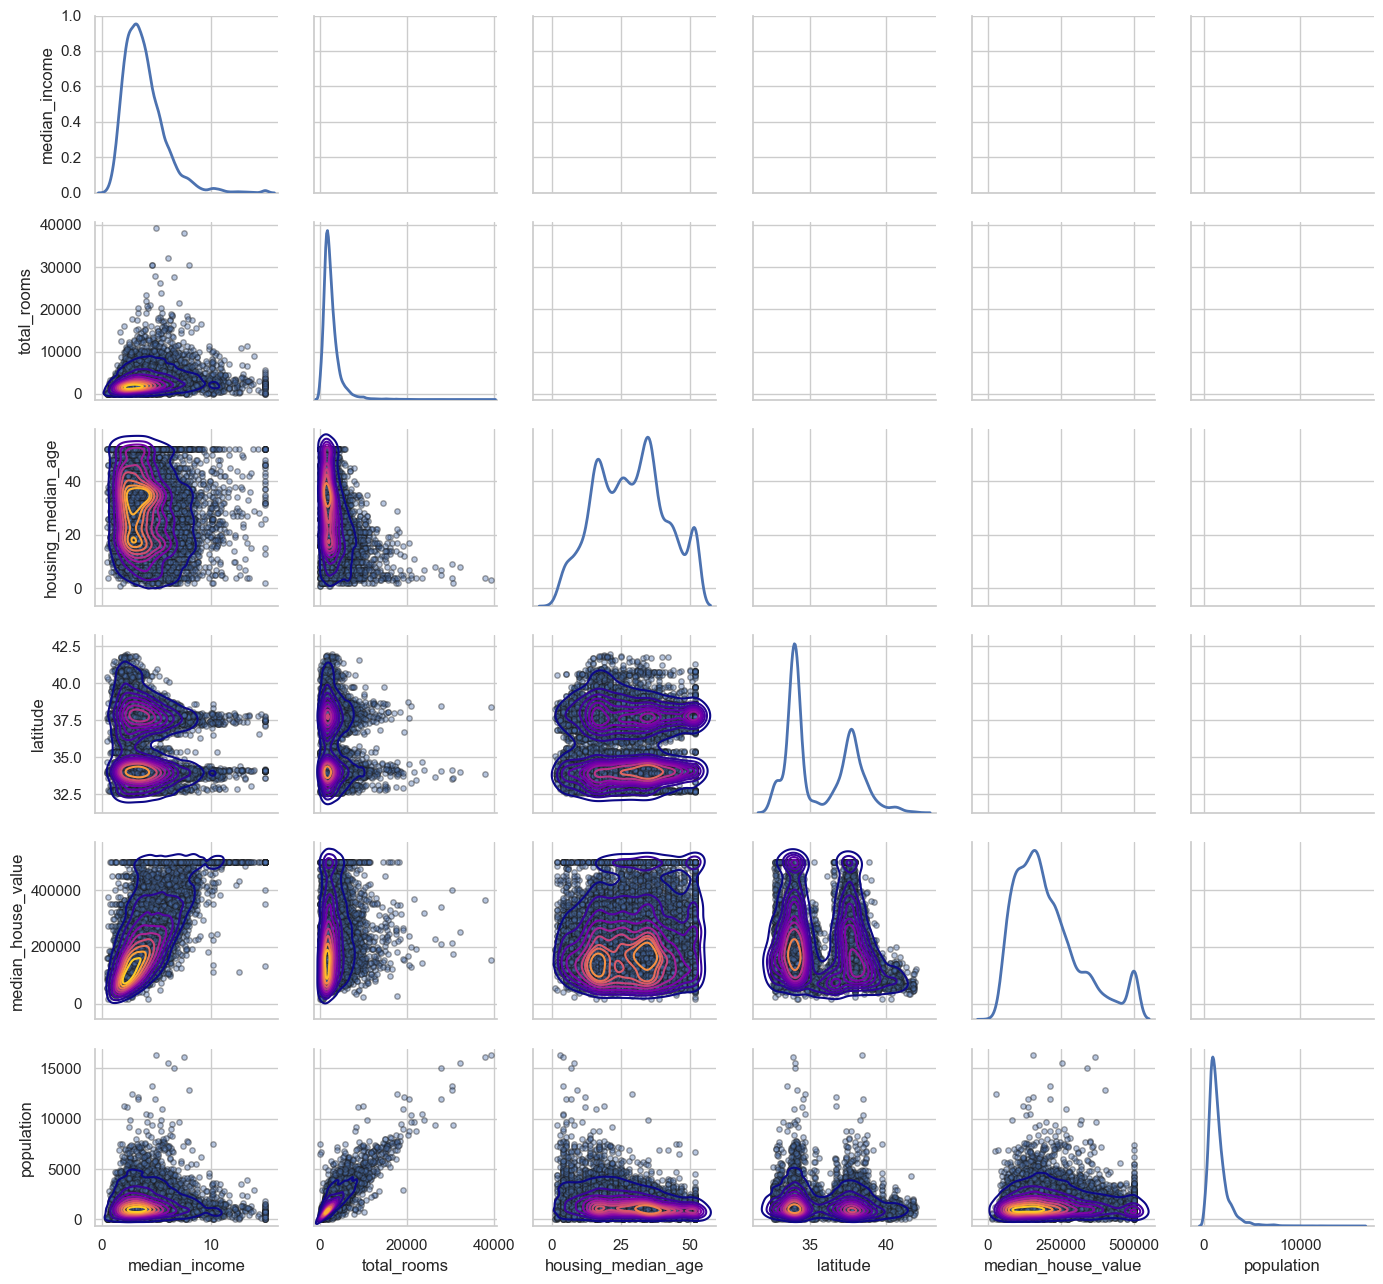

In [30]:
# Seaborn get a little slow, let's plot some interesting features
tlist = ['median_income','total_rooms','housing_median_age','latitude','median_house_value','population']
snsPairGrid(trdata[tlist]) 

* median_house_value and median_income relation looks quite linear, with a fair bit of deviation normal to the linear line, we can also note a visible upper limit for all values of 'median_income', which in two dimensions, definitely looks out of place.
* In median_house_age vs median_house_value relation, it looks like the data is completely spread out all over the place; KDE helping the identification of two peaks roughtly 20 years appart, perhaps these peaks are associated with increasing affordability (given they are concentrated in the lower half)
* We an note an additional peak near the peak values of both features as well. The relation is very nonlinear, being scattered everywhere, having data in almost all parts of the graph.
* median_house_value & total_rooms,population seem like quite complex features to model, KDE suggests it's heavily concentrated at lower values for the two, with a fair bit at larger values & a lot of data outside the main clusters, classifiable as outliers.
* Many of our features have quite different axis scales, higher values might be interpreted as more important, so scaling should definitely be considered.

## Geospatial multivariate data

* Multivariate visualisating can be even more insightful than bivariate. Adding 'hue'/colour to scattered data gives the data an extra dimension we can interpred provided there is minimal overlap
* Geographic plotting is one form of such visualisation. It would be interesting to understand how geography influences various features.
* We're dealing with geographical data, so geopandas is quite useful, so is folium & plotly
* Other modules you might like to add (mainly for 3D) k3d and pyvista are awesome for multivariate visualisation too.

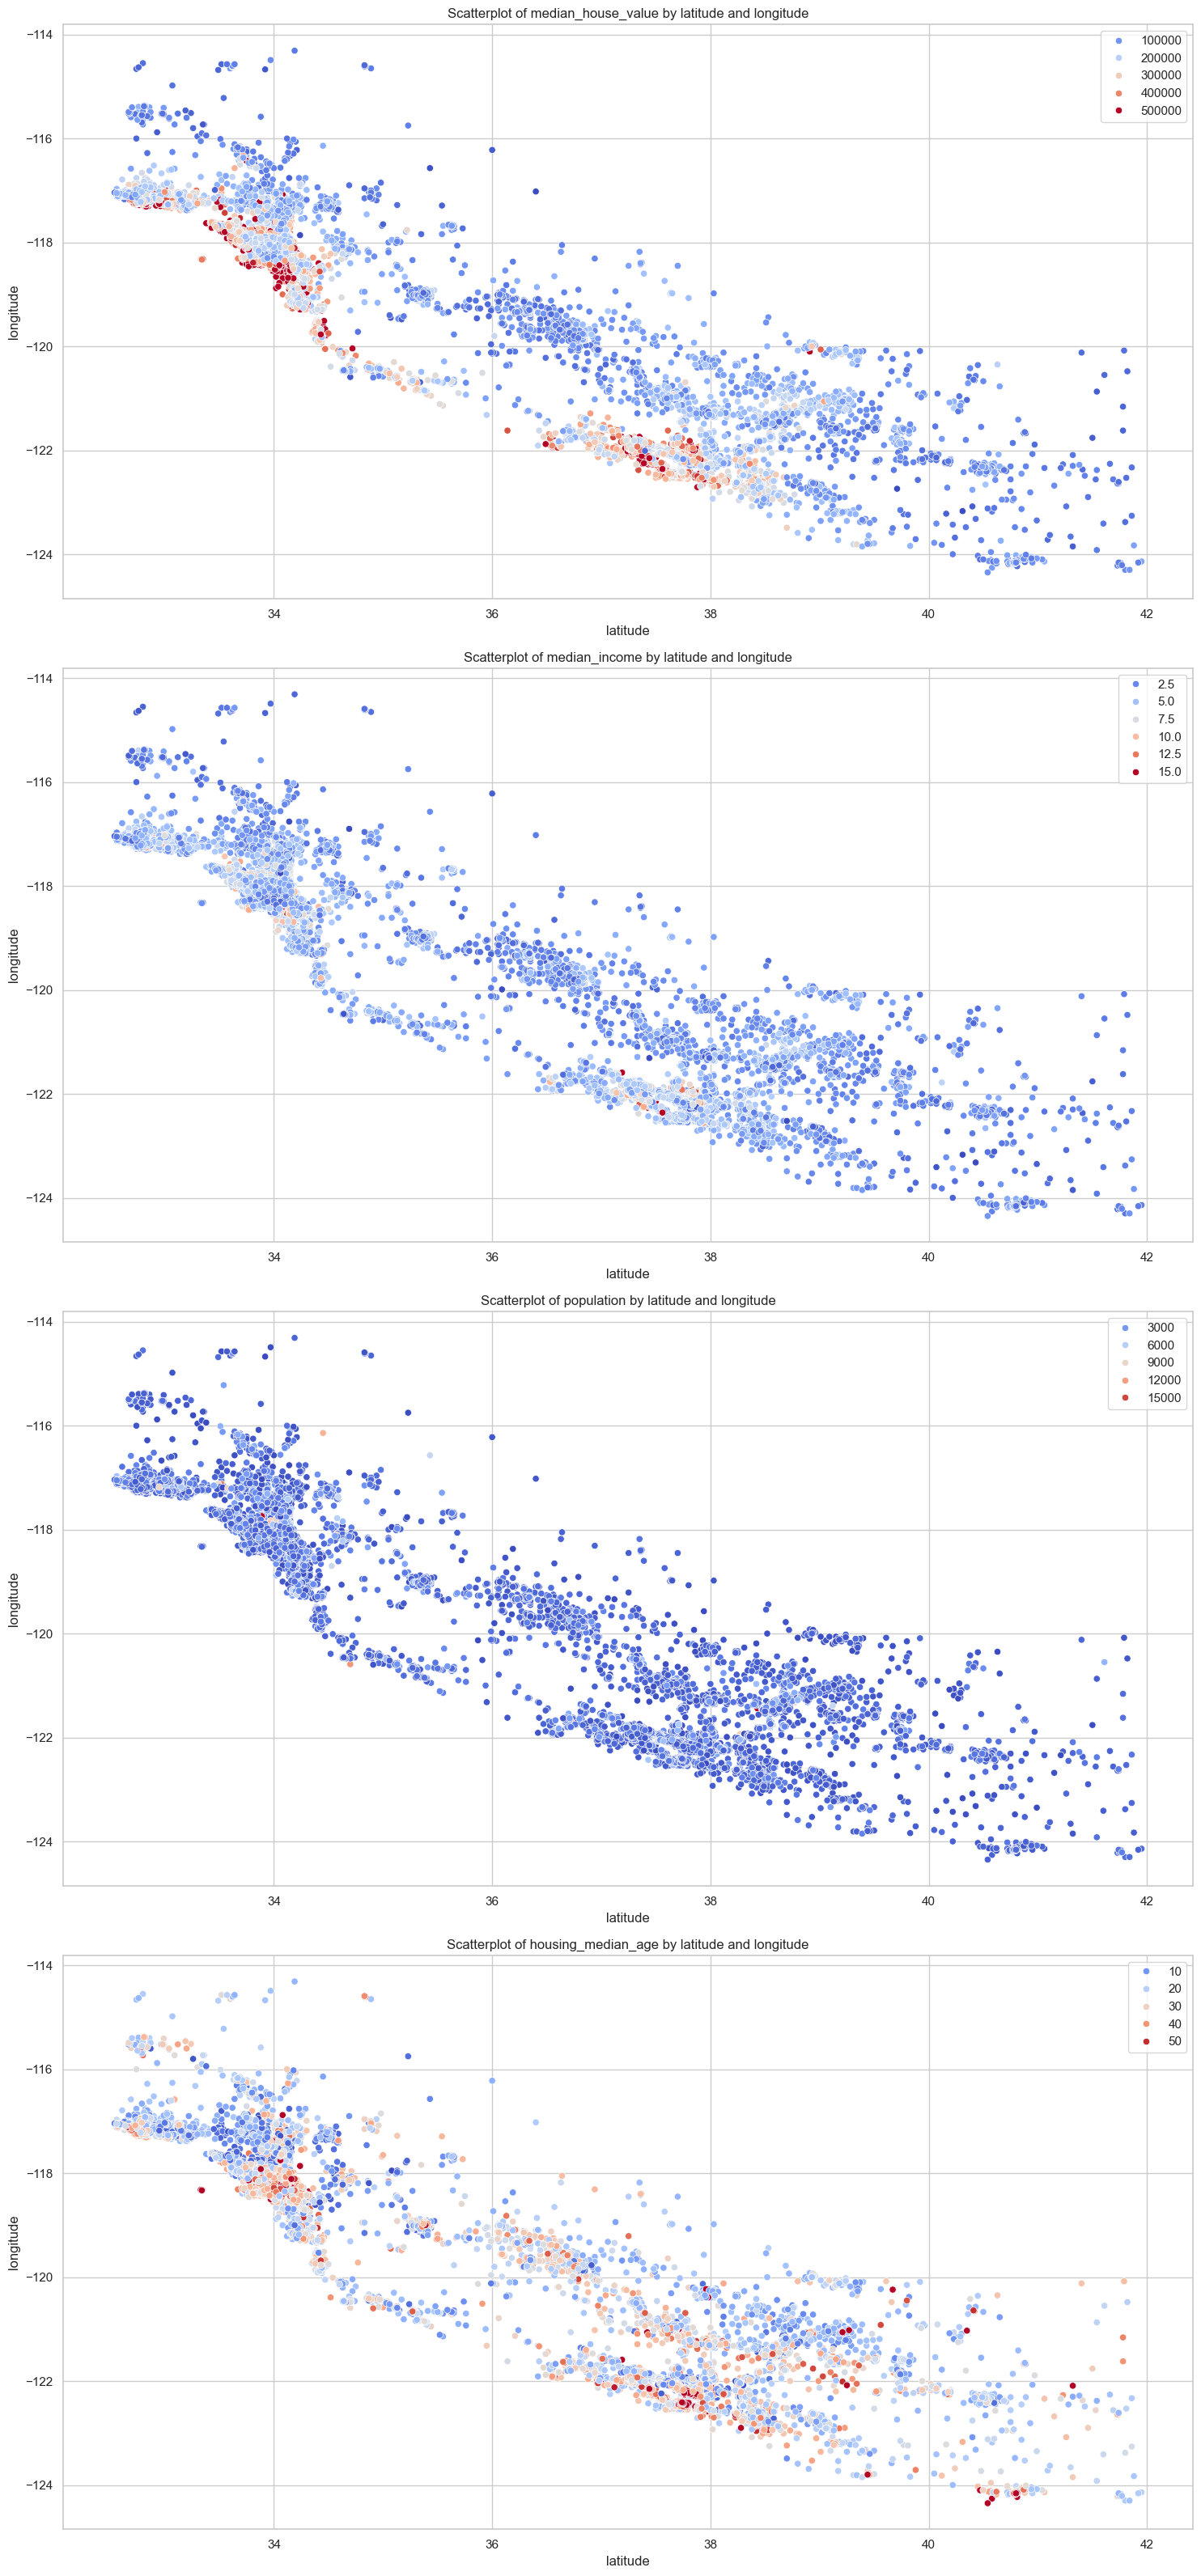

In [104]:
def plot_scatterplots(df, features, latitude='latitude', longitude='longitude'):
    '''
    Plots scatterplots for the specified features against latitude and longitude.
    
    Parameters:
    df (DataFrame): The DataFrame containing the data.
    features (list): A list of feature names to plot.
    latitude (str): The column name for latitude. Default is 'latitude'.
    longitude (str): The column name for longitude. Default is 'longitude'.
    '''
    plt.figure(figsize=(15, 8 * len(features)))

    for i, feature in enumerate(features):
        plt.subplot(len(features), 1, i + 1)
        sns.scatterplot(x=latitude, y=longitude, data=df, hue=feature, palette="coolwarm")
        plt.title(f'Scatterplot of {feature} by {latitude} and {longitude}')
        plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

features_to_plot = ['median_house_value', 'median_income', 'population', 'housing_median_age']
plot_scatterplots(trdata, features_to_plot)

# REVIEWING OUTLIERS

**Outlier @ housing_median_age == 52**
We inspected the dataset histogram, and noted a rather odd cluster at a value of 52, 1D data doesn't quite tell the entire story, certainly our histogram data transitions quite steadily, but perhaps during this year it was very affordable. 2D pairplots tend to show this data as being somewhat more like a constraint more than anything, looking very odd compared to the rest of the data (lines in data). Overall, it's not entirely conclusive.

**Outlier @ median_house_value == 500,001**
Unlike housing_median_age, it is very doubtful that the outlier spike is not a categorically defined summation of all cases above the maximum median_house_value, let's remove this subset, and keep the other.

**Less noticable outliers**
Having just plotted population in a multivariate plot, we would have noted how the scale created values that are barely visible to the eye, in fact, a model with poorly allocated weights to these outliers can sevely degrade in accuracy, one counter to these outliers is a weight function approach, such as Inverse Distance Weighting (IDW) in models such as Weighted Least Sqaures (WLS) or Covariance Functions in Gaussian Process Models, BR() unfortunately doesn't have this functionality, so we'll have to attempt a common approach known as skewness correction via feature transformation. I thought we'd give it a go and attempt to implement these functions into the BR() model as well, why not.

Let's remove the outlier for median_house_value by simply selecting the maximum (which works here)



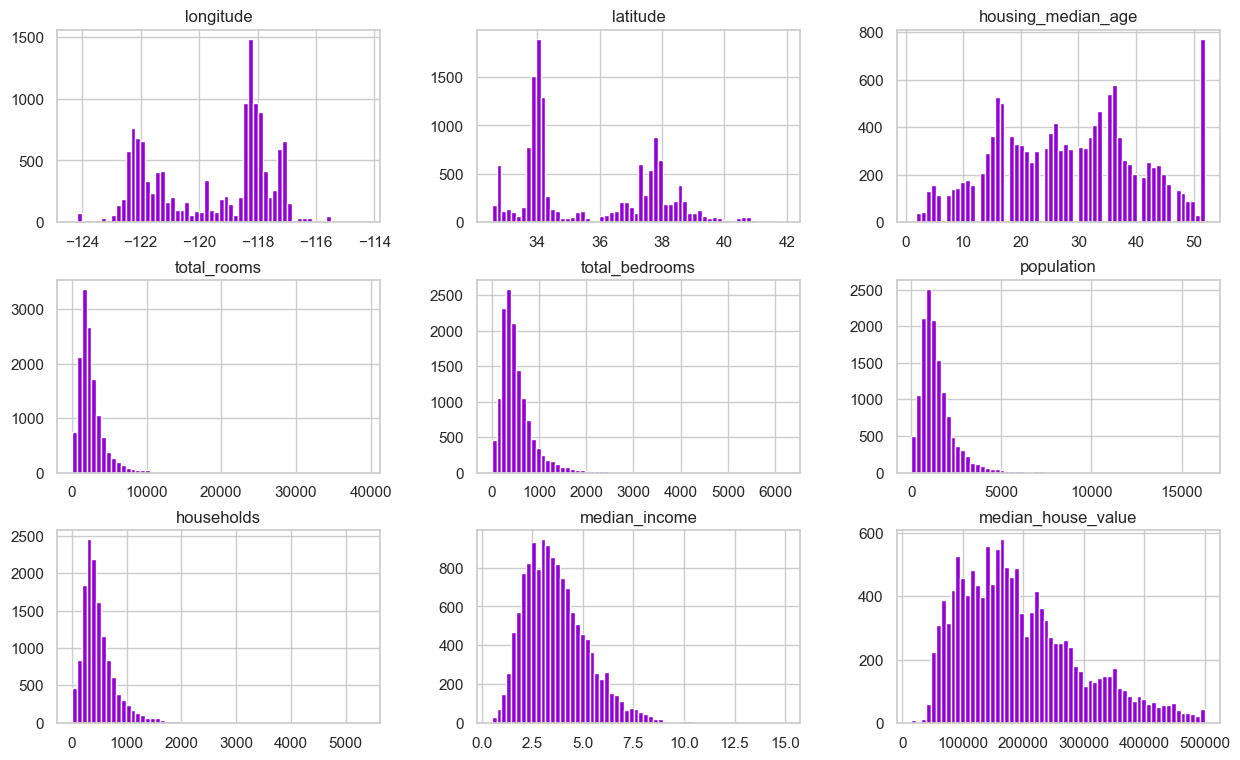

In [105]:
# trdata_upd : training data w/ removed outliers
maxval2 = trdata['median_house_value'].max() # get the maximum value
trdata_upd = trdata[trdata['median_house_value'] != maxval2] 
tedata_upd = tedata[tedata['median_house_value'] != maxval2]
trdata_upd.hist(bins=60, figsize=(15,9),color=color1);plt.show() # looks like its completely removed.

# FEATURE ENGINEERING


* We want to make sure we feed the model data that is most relevant to the prediction of a target variable, perhaps as less overlapping as possible as well.
* Features with very high correlation teach a model similar things, multiple times, maybe consider combing them and dropping the others.


In [106]:
# Make a feature that contains both longtitude & latitude
trdata_upd['diag_coord'] = (trdata_upd['longitude'] + trdata_upd['latitude'])         # 'diagonal coordinate', works for this coord
trdata_upd['bedroom_ratio'] = trdata_upd['total_bedrooms'] / trdata_upd['total_rooms']
trdata_upd['household_rooms'] = trdata_upd['total_rooms'] / trdata_upd['households']
trdata_upd = trdata_upd.join(pd.get_dummies(trdata_upd.ocean_proximity)).drop(['ocean_proximity'], axis=1)

tedata_upd['diag_coord'] = (tedata_upd['longitude'] + tedata_upd['latitude'])         # 'diagonal coordinate', works for this coord
tedata_upd['bedroom_ratio'] = tedata_upd['total_bedrooms'] / tedata_upd['total_rooms']
tedata_upd['household_rooms'] = tedata_upd['total_rooms'] / tedata_upd['households']
tedata_upd = tedata_upd.join(pd.get_dummies(tedata_upd.ocean_proximity)).drop(['ocean_proximity'], axis=1)
one_hot_columns = ['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']
trdata_upd[one_hot_columns] = trdata_upd[one_hot_columns].astype(int)
tedata_upd[one_hot_columns] = tedata_upd[one_hot_columns].astype(int)
trdata_upd

C:\Users\TEJ\AppData\Local\Temp\ipykernel_26104\2570065537.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trdata_upd['diag_coord'] = (trdata_upd['longitude'] + trdata_upd['latitude'])         # 'diagonal coordinate', works for this coord
C:\Users\TEJ\AppData\Local\Temp\ipykernel_26104\2570065537.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trdata_upd['bedroom_ratio'] = trdata_upd['total_bedrooms'] / trdata_upd['total_rooms']
C:\Users\TEJ\AppData\Local\Temp\ipykernel_26104\2570065537.py:4: Settin

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
11440    -117.97     33.73                18.0       3698.0           574.0   
19986    -119.32     36.21                25.0       2360.0           460.0   
11655    -118.01     33.84                29.0       3740.0           691.0   
14527    -117.14     32.92                 7.0       1308.0           418.0   
19866    -119.32     36.33                18.0       2603.0           478.0   
...          ...       ...                 ...          ...             ...   
18448    -121.81     37.23                16.0       1674.0           281.0   
7985     -118.16     33.86                26.0       6607.0          1663.0   
18687    -121.79     37.03                18.0        943.0           213.0   
19776    -122.23     39.86                21.0       1730.0           350.0   
14148    -117.08     32.73                36.0       1158.0           218.0   

       population  households  median_income  median_house_value  diag_coord  \
11440      2046.0       614.0         6.2984            269800.0      -84.24   
19986      1424.0       436.0         2.3152             63100.0      -83.11   
11655      1724.0       638.0         3.9628            215600.0      -84.17   
14527       766.0       390.0         3.2151            106300.0      -84.22   
19866      1158.0       423.0         4.5938            150500.0      -82.99   
...           ...         ...            ...                 ...         ...   
18448       850.0       254.0         5.3157            253300.0      -84.58   
7985       4066.0      1558.0         2.5068            156300.0      -84.30   
18687       544.0       179.0         3.9340            228600.0      -84.76   
19776       982.0       322.0         1.8375             79800.0      -82.37   
14148       619.0       233.0         3.6125            122500.0      -84.35   

       bedroom_ratio  household_rooms  <1H OCEAN  INLAND  ISLAND  NEAR BAY  \
11440       0.155219         6.022801          1       0       0         0   
19986       0.194915         5.412844          0       1       0         0   
11655       0.184759         5.862069          1       0       0         0   
14527       0.319572         3.353846          1       0       0         0   
19866       0.183634         6.153664          0       1       0         0   
...              ...              ...        ...     ...     ...       ...   
18448       0.167861         6.590551          1       0       0         0   
7985        0.251703         4.240693          1       0       0         0   
18687       0.225875         5.268156          1       0       0         0   
19776       0.202312         5.372671          0       1       0         0   
14148       0.188256         4.969957          0       0       0         0   

       NEAR OCEAN  
11440           0  
19986           0  
11655           0  
14527           0  
19866           0  
...           ...  
18448           0  
7985            0  
18687           0  
19776           0  
14148           1  

[13776 rows x 17 columns]

<Axes: >

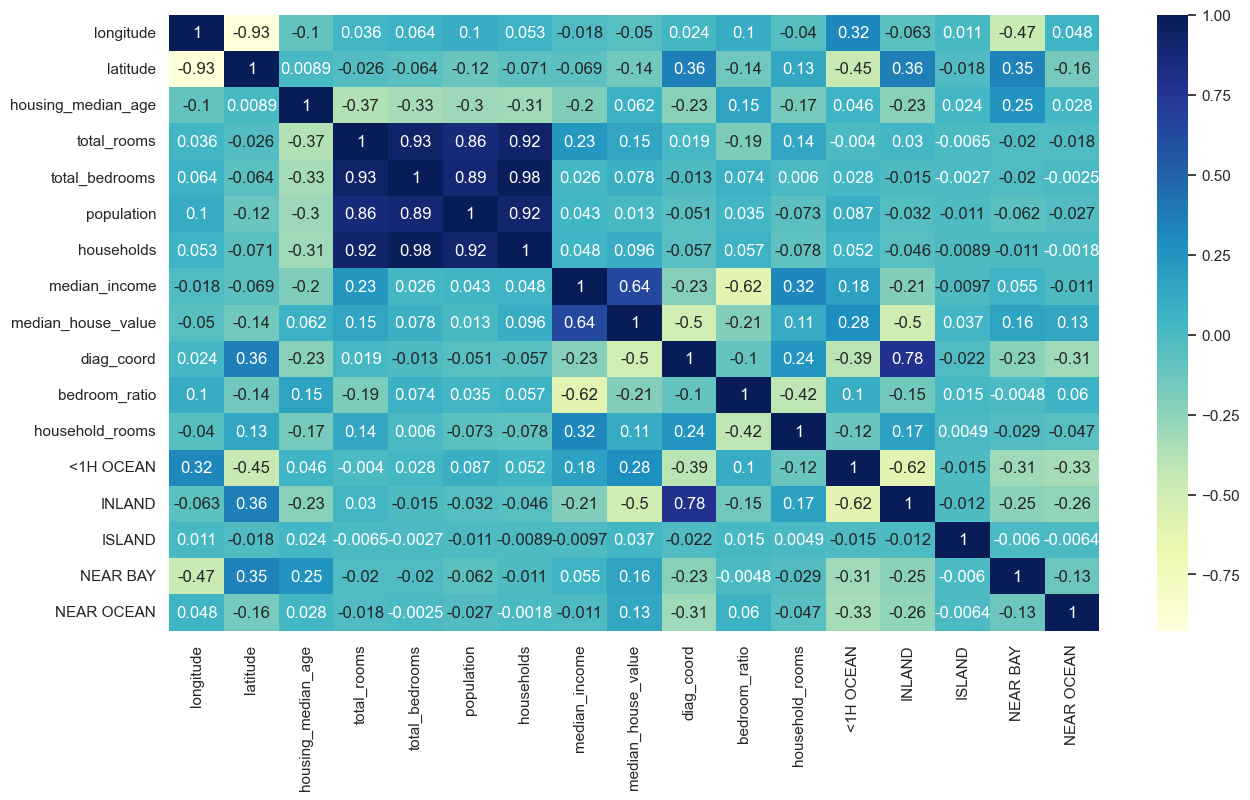

In [80]:
plt.figure(figsize=(15,8))
sns.heatmap((trdata_upd.select_dtypes(include=[np.number]).corr()), annot=True, cmap="YlGnBu")

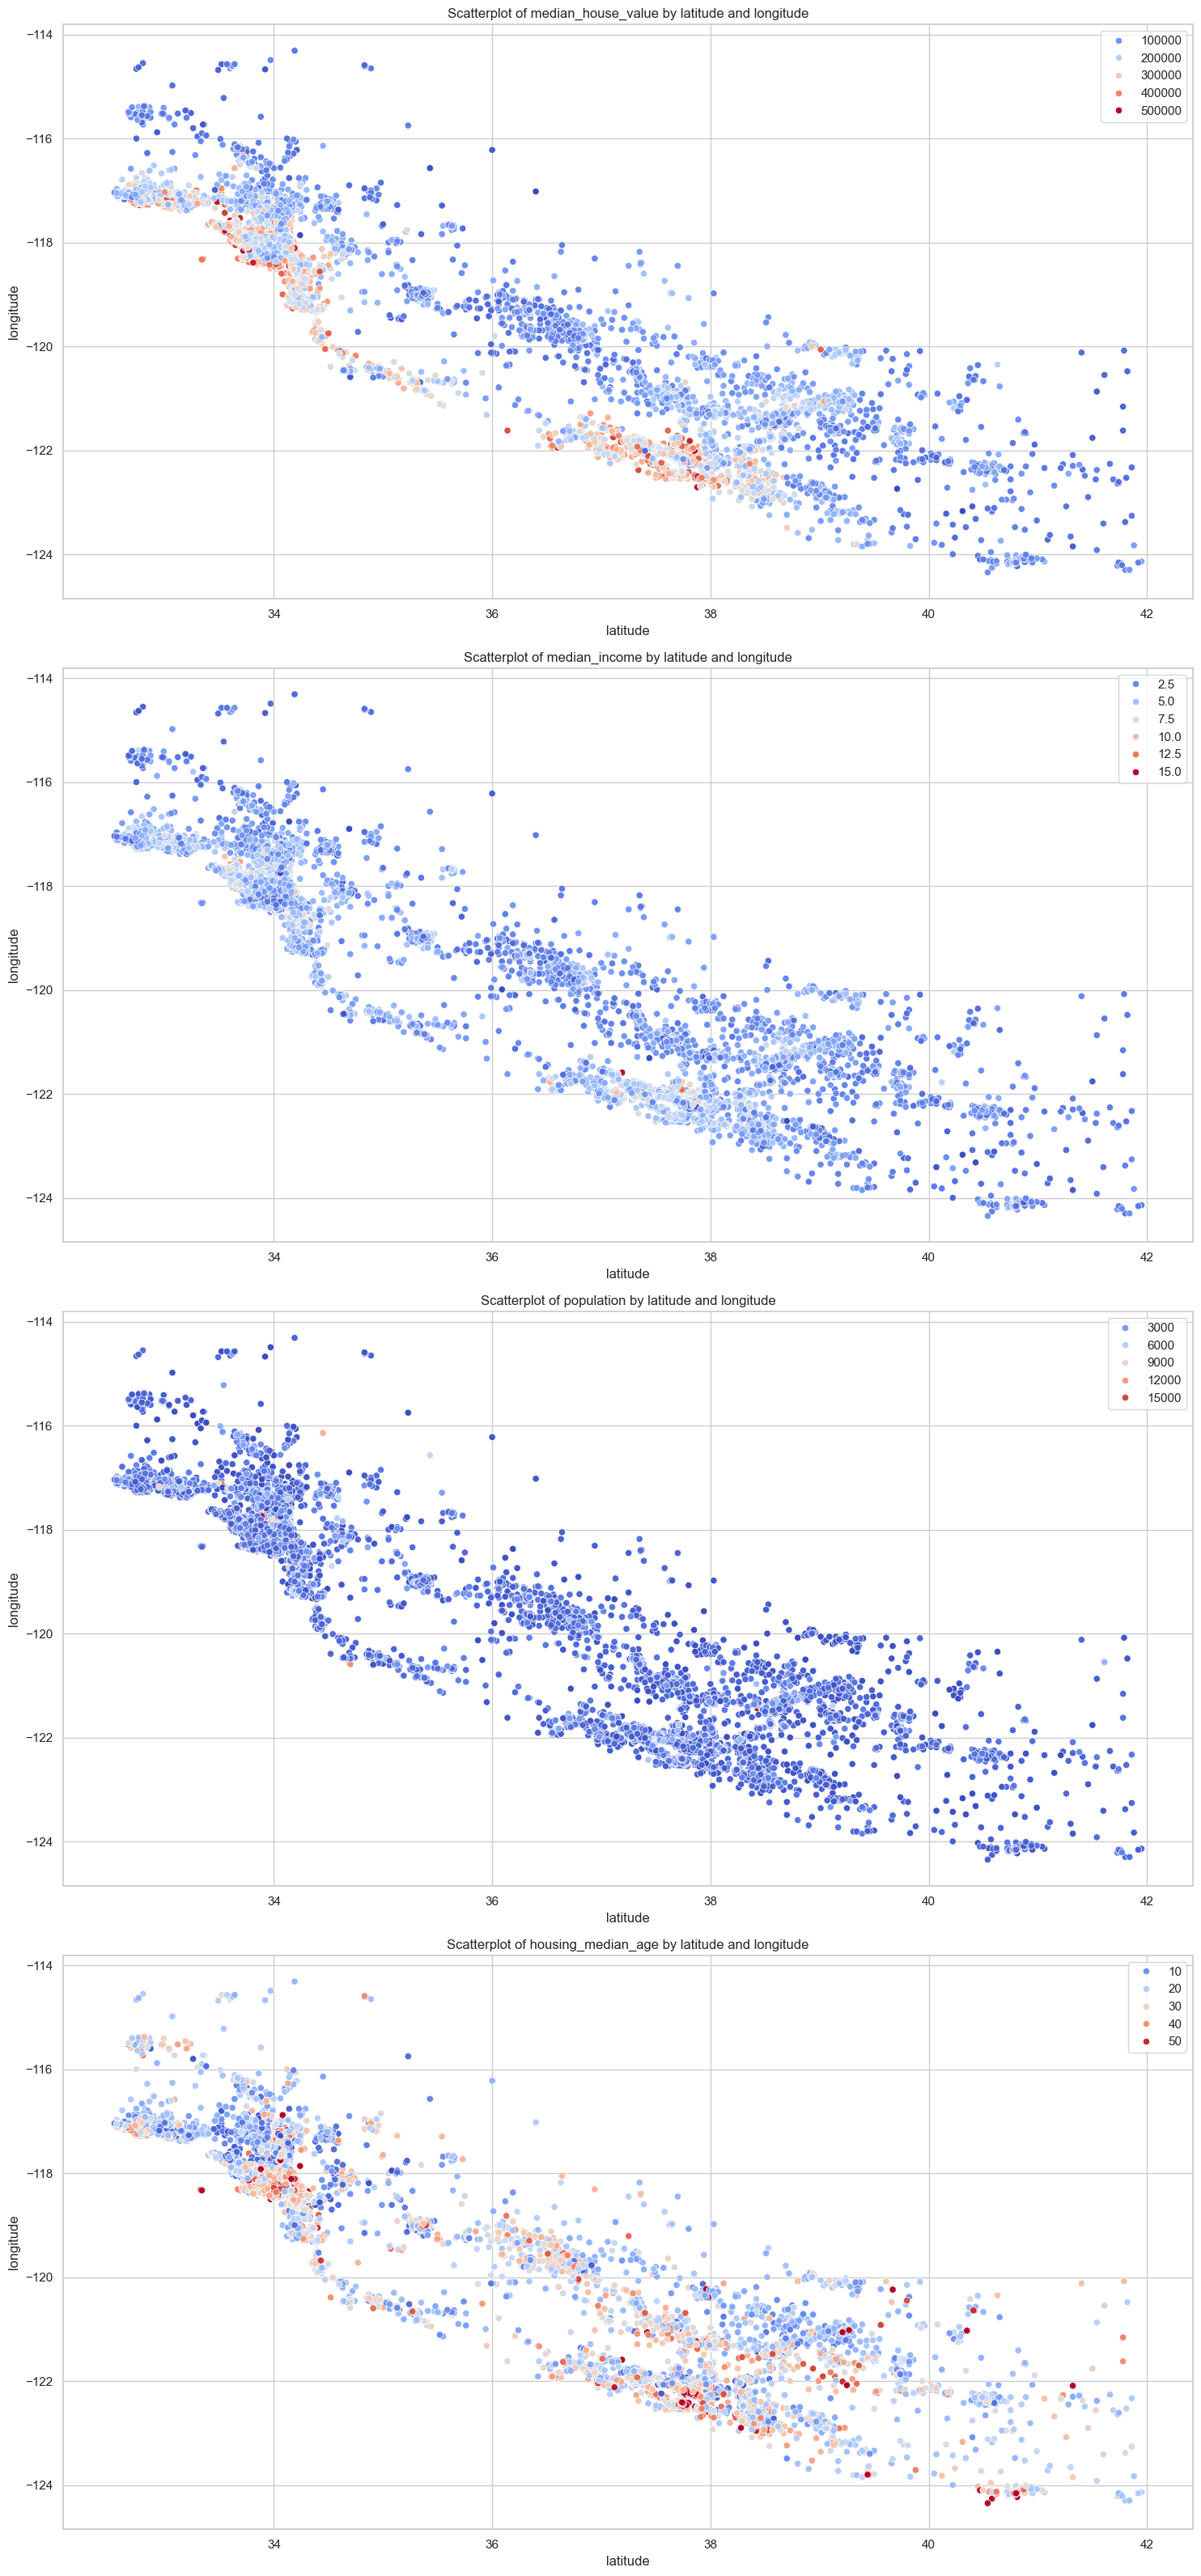

In [81]:
features_to_plot = ['median_house_value', 'median_income', 'population', 'housing_median_age']
plot_scatterplots(trdata_upd, features_to_plot)

In [107]:
trdata_upd

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
11440    -117.97     33.73                18.0       3698.0           574.0   
19986    -119.32     36.21                25.0       2360.0           460.0   
11655    -118.01     33.84                29.0       3740.0           691.0   
14527    -117.14     32.92                 7.0       1308.0           418.0   
19866    -119.32     36.33                18.0       2603.0           478.0   
...          ...       ...                 ...          ...             ...   
18448    -121.81     37.23                16.0       1674.0           281.0   
7985     -118.16     33.86                26.0       6607.0          1663.0   
18687    -121.79     37.03                18.0        943.0           213.0   
19776    -122.23     39.86                21.0       1730.0           350.0   
14148    -117.08     32.73                36.0       1158.0           218.0   

       population  households  median_income  median_house_value  diag_coord  \
11440      2046.0       614.0         6.2984            269800.0      -84.24   
19986      1424.0       436.0         2.3152             63100.0      -83.11   
11655      1724.0       638.0         3.9628            215600.0      -84.17   
14527       766.0       390.0         3.2151            106300.0      -84.22   
19866      1158.0       423.0         4.5938            150500.0      -82.99   
...           ...         ...            ...                 ...         ...   
18448       850.0       254.0         5.3157            253300.0      -84.58   
7985       4066.0      1558.0         2.5068            156300.0      -84.30   
18687       544.0       179.0         3.9340            228600.0      -84.76   
19776       982.0       322.0         1.8375             79800.0      -82.37   
14148       619.0       233.0         3.6125            122500.0      -84.35   

       bedroom_ratio  household_rooms  <1H OCEAN  INLAND  ISLAND  NEAR BAY  \
11440       0.155219         6.022801          1       0       0         0   
19986       0.194915         5.412844          0       1       0         0   
11655       0.184759         5.862069          1       0       0         0   
14527       0.319572         3.353846          1       0       0         0   
19866       0.183634         6.153664          0       1       0         0   
...              ...              ...        ...     ...     ...       ...   
18448       0.167861         6.590551          1       0       0         0   
7985        0.251703         4.240693          1       0       0         0   
18687       0.225875         5.268156          1       0       0         0   
19776       0.202312         5.372671          0       1       0         0   
14148       0.188256         4.969957          0       0       0         0   

       NEAR OCEAN  
11440           0  
19986           0  
11655           0  
14527           0  
19866           0  
...           ...  
18448           0  
7985            0  
18687           0  
19776           0  
14148           1  

[13776 rows x 17 columns]

# 7 ML MODELS TO PREDICT MEDIAN HOUSE VALUE
* We can see that there is a high coreleation with the engineered features.
* And also for testing purposes i have ran a base model regressor to check wether the model is learning any useful information from the engineered features and it does. The RMSE was significantly improved with the trdata_upd
* Additionally we noted that several features (total_rooms,total_bedrooms,population) have very high correlation to one another, so it's interesting to find out if a removal of a few of them would have any affect on the model performance

In [108]:
y_trdata_upd = trdata_upd['median_house_value']
y_tedata_upd = tedata_upd['median_house_value']
X_trdata_upd = trdata_upd.drop('median_house_value', axis =1)
X_tedata_upd = tedata_upd.drop('median_house_value', axis =1)


In [114]:
model = RandomForestRegressor(random_state=42)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100],
    'max_features': [ 'sqrt', 'log2', None],
    'max_depth': [10, None],
    'min_samples_split': [ 5, 10],
    'min_samples_leaf': [ 2, 4],
    'bootstrap': [True, False]
}

# Perform Grid Search with Cross Validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_trdata_upd, y_trdata_upd)

# Best model from Randomized Search
best_model = grid_search.best_estimator_

# Train the best model
best_model.fit(X_trdata_upd, y_trdata_upd)

# Predict on the test set
y_pred = best_model.predict(X_tedata_upd)


Fitting 3 folds for each of 48 candidates, totalling 144 fits


Root Mean Squared Error (RMSE): 41873.98843647372
Best Hyperparameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


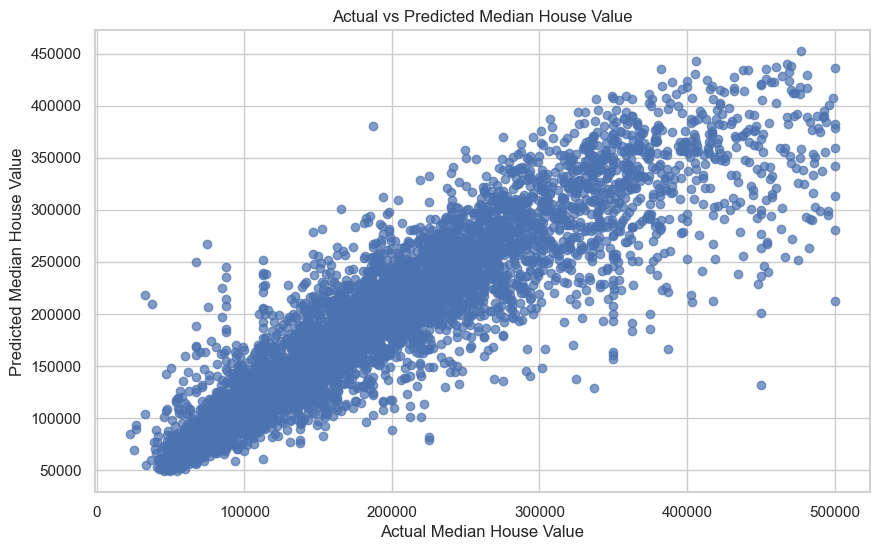

In [115]:
# Calculate the mean squared error
mse = mean_squared_error(y_tedata_upd, y_pred)
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Best Hyperparameters: {grid_search.best_params_}")

# Plot the predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_tedata_upd, y_pred, alpha=0.7)
plt.xlabel('Actual Median House Value')
plt.ylabel('Predicted Median House Value')
plt.title('Actual vs Predicted Median House Value')
plt.show()

* We can see that even a very powerful like RandomForest() can't really reduce the RMSE with the current set of feature & instance combination very much further (despite being a model that very easily can overpredict)

* An error of 41,000 is quite a large in the context of the target values & it's probably a reasonable idea to investigate the validity of the current dataset & review it

* The dataset is quite old & doesn't contain the best features comapared to more recent datasets, like the introductory House Price Problem ( which was quite fun! ), but hopefully the basic approach one can take was clear.

# 8 CONCLUSION 

* We started off with a dataset which contained missing data, we looked at an unsupervised learning approach to data imputation.

* The data analysis revealed that our data could be potentially cause issues for our model, such as nonlinearity,skewness,large variation in range,too highly correlated features to name a few.

* We obtained a model that performed significantly better than what we started off with, so it was nice to make some progress

* Additional things that could have been attemped are skewness correction & more thorough feature by feature basis influence analysis